In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.preprocessing import StandardScaler

from matplotlib import style
style.use('dark_background')
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
style.use('dark_background')

In [2]:
#reads document and standardizes user scores

df = pd.read_csv('gamereviews.csv')
df = df.drop(df.columns[[0, 1, 5]], axis=1)
df.dropna(inplace=True)
df['Userscore'] = StandardScaler().fit_transform(df[['Userscore']])

print(df.head(), df['Userscore'].describe())

     Platform  Userscore                                            Comment
0  Nintendo64   0.760493  Everything in OoT is so near at perfection, it...
1  Nintendo64   0.760493  I won't bore you with what everyone is already...
2  Nintendo64   0.760493  Anyone who gives the masterpiece below a 7 or ...
3  Nintendo64   0.760493  I'm one of those people who think that this is...
4  Nintendo64   0.760493   This game is the highest rated game on Metacr... count    2.839600e+05
mean    -2.562318e-17
std      1.000002e+00
min     -2.432663e+00
25%     -1.974537e-01
50%      4.411776e-01
75%      7.604933e-01
max      7.604933e-01
Name: Userscore, dtype: float64


In [3]:
#converts scores to sentiment

df['Polarity'] = df['Userscore'].apply(lambda x: 'Positive' if (x > .76) else('Neutral' if (x <= .76) and (x >= -.197)  else 'Negative'))
df.head()

,Platform,Userscore,Comment,Polarity
0,Nintendo64,0.760493,"Everything in OoT is so near at perfection, it...",Positive
1,Nintendo64,0.760493,I won't bore you with what everyone is already...,Positive
2,Nintendo64,0.760493,Anyone who gives the masterpiece below a 7 or ...,Positive
3,Nintendo64,0.760493,I'm one of those people who think that this is...,Positive
4,Nintendo64,0.760493,This game is the highest rated game on Metacr...,Positive


<AxesSubplot:>

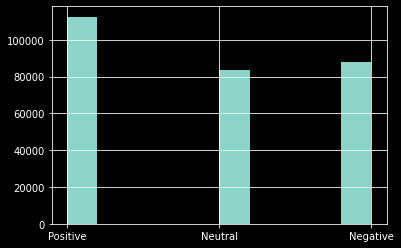

In [4]:
df['Polarity'].hist()

In [5]:
#function to get rid of stopwords and all non-letter characters

def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [6]:
#applies function and also converts all letters to lowercase

df['Comment'] = df['Comment'].apply(get_text_processing)
df['Comment'] = df['Comment'].str.lower()
df.head()

,Platform,Userscore,Comment,Polarity
0,Nintendo64,0.760493,everything oot near perfection really wonder g...,Positive
1,Nintendo64,0.760493,wont bore everyone already saying amazing game...,Positive
2,Nintendo64,0.760493,anyone gives masterpiece 7 8 either hate astou...,Positive
3,Nintendo64,0.760493,im one people think greatest game time matter ...,Positive
4,Nintendo64,0.760493,game highest rated game metacritic good reason...,Positive


In [7]:
#for sparse categorical cross entropy loss function

n = df['Userscore'].apply(lambda x: 2 if (x > .76) else(1 if (x <= .76) and (x >= -.197)  else 0))
n.head()

0    2
1    2
2    2
3    2
4    2
Name: Userscore, dtype: int64

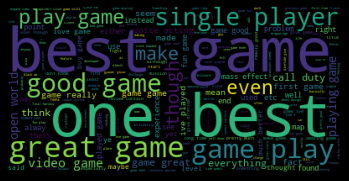

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(df['Comment']))

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
#one hot encode polarity

p = df['Polarity']
onehot = pd.get_dummies(p)
df.drop(['Polarity', 'Platform', 'Userscore'], axis=1, inplace=True)
df = pd.concat([df, onehot], axis=1)
df = df.reset_index(drop=True)
df

,Comment,Negative,Neutral,Positive
0,everything oot near perfection really wonder g...,0,0,1
1,wont bore everyone already saying amazing game...,0,0,1
2,anyone gives masterpiece 7 8 either hate astou...,0,0,1
3,im one people think greatest game time matter ...,0,0,1
4,game highest rated game metacritic good reason...,0,0,1
...,...,...,...,...
283955,extremely similar eo4 obviously isnt bad thing...,1,0,0
283956,typical overrated atlus trash game liked since...,1,0,0
283957,find story mode annoying characters intrusive ...,0,1,0
283958,pretty good certainly lacks visual audio polis...,0,1,0


In [10]:
X = df['Comment']
y = df.drop('Comment', axis=1)
print(X, y)

0         everything oot near perfection really wonder g...
1         wont bore everyone already saying amazing game...
2         anyone gives masterpiece 7 8 either hate astou...
3         im one people think greatest game time matter ...
4         game highest rated game metacritic good reason...
                                ...                        
283955    extremely similar eo4 obviously isnt bad thing...
283956    typical overrated atlus trash game liked since...
283957    find story mode annoying characters intrusive ...
283958    pretty good certainly lacks visual audio polis...
283959    first game etrian series hard time got used ch...
Name: Comment, Length: 283960, dtype: object         Negative  Neutral  Positive
0              0        0         1
1              0        0         1
2              0        0         1
3              0        0         1
4              0        0         1
...          ...      ...       ...
283955         1        0         0
283956 

In [11]:
#apply lancaster stemming

import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

lancaster = LancasterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lancaster.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

XS = pd.DataFrame(X)
for i in range(0, len(X)):
    XS.loc[i] = stemSentence(X[i])
    
print(XS)

                                                  Comment
0       everyth oot near perfect real wond gam hug fan...
1       wont bor everyon already say amaz gam yo fent ...
2       anyon giv masterpiec 7 8 eith hat astound zeld...
3       im on peopl think greatest gam tim mat qual ga...
4       gam highest rat gam metacrit good reason tak e...
...                                                   ...
283955  extrem simil eo4 obvy isnt bad thing id say we...
283956  typ over atl trash gam lik sint oldtim hardc p...
283957  find story mod annoy charact intrud story clas...
283958  pretty good certain lack vis audio pol iv many...
283959  first gam et sery hard tim got us check map du...

[283960 rows x 1 columns]


In [12]:
#dim reduction by freq filtering

vect = CountVectorizer(strip_accents = 'unicode', max_df = .995, min_df = .005)
XX = vect.fit_transform(XS['Comment'])

tfidf = TfidfTransformer()
XX = tfidf.fit_transform(XX)
XX.shape

(283960, 1460)

In [13]:
#dim reduction by SVD
vect = CountVectorizer(strip_accents = 'unicode')
X2 = vect.fit_transform(XS['Comment'])

tfidf = TfidfTransformer()
X2 = tfidf.fit_transform(XX)
X2.shape

from numpy import array
from scipy.sparse.linalg import svds

u, s, v = svds(X2)
u.shape

(283960, 6)

In [14]:
#dim reduction by clustering

import numpy as np
from sklearn import datasets, cluster

agglo = cluster.FeatureAgglomeration(n_clusters = 42)
agglo.fit(X2.toarray())
XR = agglo.transform(X2.toarray())
XR.shape

(283960, 42)

In [15]:
#train test split for each reduced df

from sklearn.model_selection import train_test_split

xtr, xte, ytr, yte = train_test_split(XX, p, test_size = 0.2, random_state = 42)
xtru, xteu, ytru, yteu = train_test_split(u, p, test_size = 0.2, random_state = 42)
xtrr, xter, ytrr, yter = train_test_split(XR, p, test_size = 0.2, random_state = 42)

In [16]:
#packages for validation

from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [18]:
knn = KNeighborsClassifier(300)
knn.fit(xtr, ytr)
ypr = knn.predict(xte)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#freq filtered model: accuracy of .41, not a good model

              precision    recall  f1-score       support
Negative       0.614665  0.022265  0.042973  17696.000000
Neutral        0.441989  0.019141  0.036693  16718.000000
Positive       0.397803  0.985298  0.566776  22378.000000
accuracy       0.400813  0.400813  0.400813      0.400813
macro avg      0.484819  0.342235  0.215481  56792.000000
weighted avg   0.478383  0.400813  0.247521  56792.000000


In [19]:
knn = KNeighborsClassifier(300)
knn.fit(xtru, ytru)
ypr = knn.predict(xteu)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#SVD model: accuracy of .54, better than before

              precision    recall  f1-score       support
Negative       0.604553  0.681284  0.640629  17696.000000
Neutral        0.468793  0.329764  0.387176  16718.000000
Positive       0.616142  0.690812  0.651344  22378.000000
accuracy       0.581561  0.581561  0.581561      0.581561
macro avg      0.563163  0.567287  0.559716  56792.000000
weighted avg   0.569155  0.581561  0.570242  56792.000000


In [20]:
knn = KNeighborsClassifier(300)
knn.fit(xtrr, ytrr)
ypr = knn.predict(xter)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .51, relatively ok performance

              precision    recall  f1-score       support
Negative       0.498493  0.738189  0.595112  17696.000000
Neutral        0.445102  0.197871  0.273954  16718.000000
Positive       0.593392  0.613996  0.603518  22378.000000
accuracy       0.530198  0.530198  0.530198      0.530198
macro avg      0.512329  0.516685  0.490862  56792.000000
weighted avg   0.520170  0.530198  0.503884  56792.000000


In [21]:
gnb = GaussianNB()
gnb.fit(xtru, ytru)
ypr = gnb.predict(xteu)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#skipped freq filtered df: GNB can't be performed on sparse matrix
#SVD model: accuracy of .48, worse than KNN but much faster 

              precision    recall  f1-score       support
Negative       0.462539  0.862059  0.602048  17696.000000
Neutral        0.418567  0.247039  0.310702  16718.000000
Positive       0.698795  0.435428  0.536534  22378.000000
accuracy       0.512907  0.512907  0.512907      0.512907
macro avg      0.526634  0.514842  0.483095  56792.000000
weighted avg   0.542688  0.512907  0.490469  56792.000000


In [22]:
gnb = GaussianNB()
gnb.fit(xtrr, ytrr)
ypr = gnb.predict(xter)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .5, same as above

              precision    recall  f1-score       support
Negative       0.444407  0.826910  0.578117  17696.000000
Neutral        0.387075  0.243989  0.299310  16718.000000
Positive       0.667817  0.397712  0.498530  22378.000000
accuracy       0.486195  0.486195  0.486195      0.486195
macro avg      0.499767  0.489537  0.458652  56792.000000
weighted avg   0.515562  0.486195  0.464684  56792.000000


In [23]:
#random forest was considered, but it is infeasible due to compute resources required

In [24]:
clf = make_pipeline(StandardScaler(), 
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(xtru, ytru)
ypr = clf.predict(xteu)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

##skipped freq filtered df: SVC can't be performed on sparse matrix
#SVD model: accuracy of .53, relatively good and fast performance

/home/gary/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score       support
Negative       0.562066  0.731295  0.635609  17696.000000
Neutral        0.483527  0.186984  0.269680  16718.000000
Positive       0.594074  0.724819  0.652966  22378.000000
accuracy       0.568513  0.568513  0.568513      0.568513
macro avg      0.546555  0.547699  0.519418  56792.000000
weighted avg   0.551558  0.568513  0.534729  56792.000000


In [25]:
clf = make_pipeline(StandardScaler(), 
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(xtrr, ytrr)
ypr = clf.predict(xter)
print(pd.DataFrame(classification_report(yte, ypr, output_dict=True)).transpose())

#clustered model: accuracy of .55, best performance so far

/home/gary/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score      support
Negative       0.519477  0.746044  0.612480  17696.00000
Neutral        0.479084  0.180165  0.261856  16718.00000
Positive       0.601650  0.674591  0.636036  22378.00000
accuracy       0.551310  0.551310  0.551310      0.55131
macro avg      0.533404  0.533600  0.503457  56792.00000
weighted avg   0.539965  0.551310  0.518548  56792.00000


In [1]:
#filtered freq df: highest accuracy of all models so far, but has high loss

xtrnn, xtenn, ytrnn, ytenn = train_test_split(XX.toarray(), n, test_size = 0.2, random_state = 42)

model1 = Sequential()
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=300, activation="relu"))
model1.add(Dropout(0.2))
model1.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy'])
model1.fit(xtrnn, ytrnn, epochs = 4)

NameError: name 'train_test_split' is not defined

In [18]:
#filtered freq df: .75 loss with .68 accuracy

v1 = model1.evaluate(xtenn, ytenn)
v1

1775/1775 [==============================] - 4s 2ms/step - loss: 0.7383 - sparse_categorical_crossentropy: 0.7383


[0.7382603883743286, 0.7382603883743286]

In [31]:
#SVD df: worst performance of NN models

xtrnn, xtenn, ytrnn, ytenn = train_test_split(u, n, test_size = 0.2, random_state = 42)

model2 = Sequential()
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=300, activation="relu"))
model2.add(Dropout(0.2))
model2.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy', 'mean_squared_error'])

model2.fit(xtrnn, ytrnn, epochs = 4)

Epoch 1/4
7099/7099 [==============================] - 18s 2ms/step - loss: 1.0403 - accuracy: 0.4826
Epoch 2/4
7099/7099 [==============================] - 18s 2ms/step - loss: 0.9132 - accuracy: 0.5638
Epoch 3/4
7099/7099 [==============================] - 18s 3ms/step - loss: 0.9085 - accuracy: 0.5676
Epoch 4/4
7099/7099 [==============================] - 18s 3ms/step - loss: 0.9053 - accuracy: 0.5707


In [32]:
#SVD df: .96 loss with .53 accuracy

v2 = model2.evaluate(xtenn, ytenn)
v2

1775/1775 [==============================] - 3s 1ms/step - loss: 0.9307 - accuracy: 0.5521


[0.9307006597518921, 0.5521023869514465]

In [33]:
#clustered df: bad performance for NN

xtrnn, xtenn, ytrnn, ytenn = train_test_split(XR, n, test_size = 0.2, random_state = 42)

model3 = Sequential()
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=300, activation="relu"))
model3.add(Dropout(0.2))
model3.add(Dense(units=30, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt, 
              metrics=['accuracy', 'mean_squared_error'])

model3.fit(xtrnn, ytrnn, epochs = 4)

Epoch 1/4
7099/7099 [==============================] - 19s 3ms/step - loss: 0.9969 - accuracy: 0.5255 - mean_squared_error: 1.8296
Epoch 2/4
7099/7099 [==============================] - 19s 3ms/step - loss: 0.9260 - accuracy: 0.5546 - mean_squared_error: 1.8206
Epoch 3/4
7099/7099 [==============================] - 19s 3ms/step - loss: 0.9219 - accuracy: 0.5582 - mean_squared_error: 1.8267
Epoch 4/4
7099/7099 [==============================] - 19s 3ms/step - loss: 0.9186 - accuracy: 0.5608 - mean_squared_error: 1.8195


In [34]:
#clustered df: .92 loss with .55 accuracy

v3 = model3.evaluate(xtenn, ytenn)
v3

1775/1775 [==============================] - 3s 2ms/step - loss: 0.9117 - accuracy: 0.5607 - mean_squared_error: 1.8137


[0.9116799831390381, 0.5607303977012634, 1.8136504888534546]